In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Load and clean the data
df = pd.read_excel('data/Shale Raw Data.xlsx', sheet_name='Raw Data', skiprows=1)
df = df.rename(columns={
    'Month': 'Month/Year',
    'Rig count': 'Rig Count',
    'Production per rig': 'Production per Rig (Oil)',
    'Legacy production change': 'Legacy Production Change (Oil)',
    'Total production': 'Total Production (Oil)',
    'Production per rig.1': 'Production per Rig (Gas)',
    'Legacy production change.1': 'Legacy Production Change (Gas)',
    'Total production.1': 'Total Production (Gas)',
    'region': 'Region'
})
df['Month'] = df['Month/Year'].dt.month
df['Year'] = df['Month/Year'].dt.year
df = df.dropna()


### Encoding the Date as a Numerical Feature
The total production over time is not cyclical, so converting the Month/Year into a time delta (months from the January 2007 baseline) is valid.

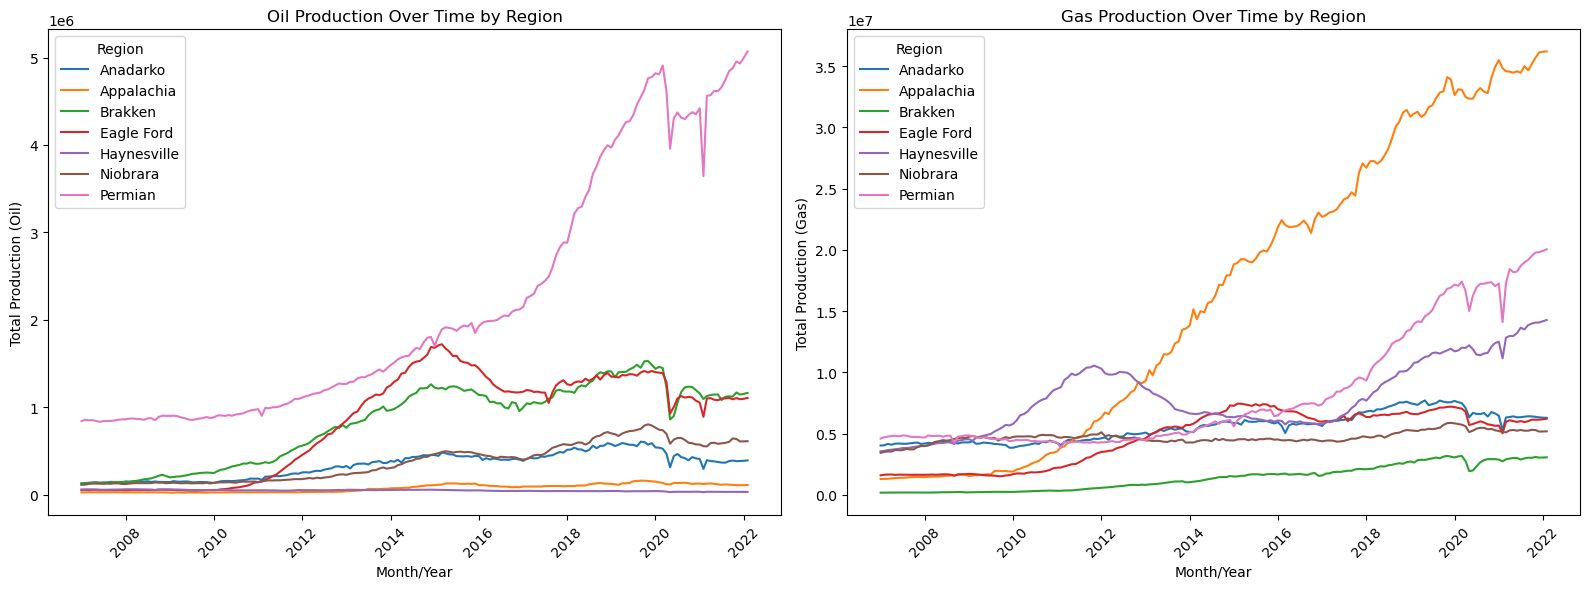

In [79]:
# Split into separate DataFrames for Oil and Gas
df_oil = df[['Month', 'Year', 'Region', 'Rig Count', 'Production per Rig (Oil)', 'Legacy Production Change (Oil)', 'Total Production (Oil)']].copy()
df_gas = df[['Month', 'Year', 'Region', 'Rig Count', 'Production per Rig (Gas)', 'Legacy Production Change (Gas)', 'Total Production (Gas)']].copy()

# Investigate relationship between Month/Year and Total Production
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Oil subplot
for region in df['Region'].unique():
    region_mask = df['Region'] == region
    axes[0].plot(
        df.loc[region_mask, 'Month/Year'],
        df.loc[region_mask, 'Total Production (Oil)'],
        label=region
    )
axes[0].set_title('Oil Production Over Time by Region')
axes[0].set_xlabel('Month/Year')
axes[0].set_ylabel('Total Production (Oil)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Region')

# Gas subplot
for region in df['Region'].unique():
    region_mask = df['Region'] == region
    axes[1].plot(
        df.loc[region_mask, 'Month/Year'],
        df.loc[region_mask, 'Total Production (Gas)'],
        label=region
    )
axes[1].set_title('Gas Production Over Time by Region')
axes[1].set_xlabel('Month/Year')
axes[1].set_ylabel('Total Production (Gas)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Region')

plt.tight_layout()
plt.show()

# Convert Month/Year to a numerical feature for modeling
df_oil['Months since Baseline (Jan 2007)'] = (df_oil['Year'] - 2007) * 12 + df_oil['Month'] - 1
df_gas['Months since Baseline (Jan 2007)'] = (df_gas['Year'] - 2007) * 12 + df_gas['Month'] - 1

df_oil = df_oil.drop(columns=['Year', 'Month'])
df_gas = df_gas.drop(columns=['Year', 'Month'])


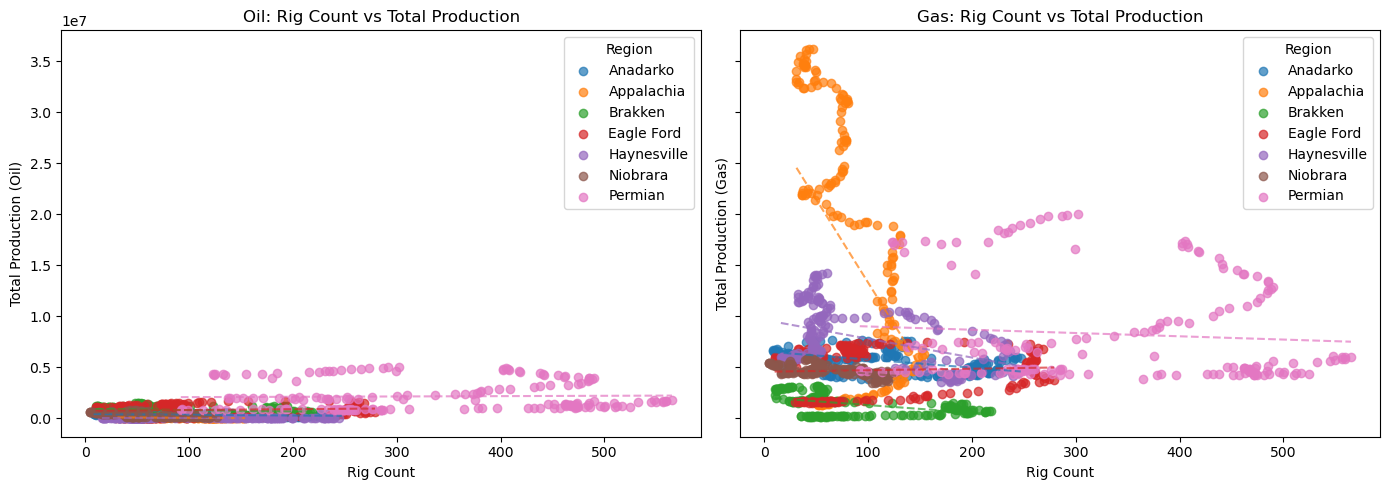

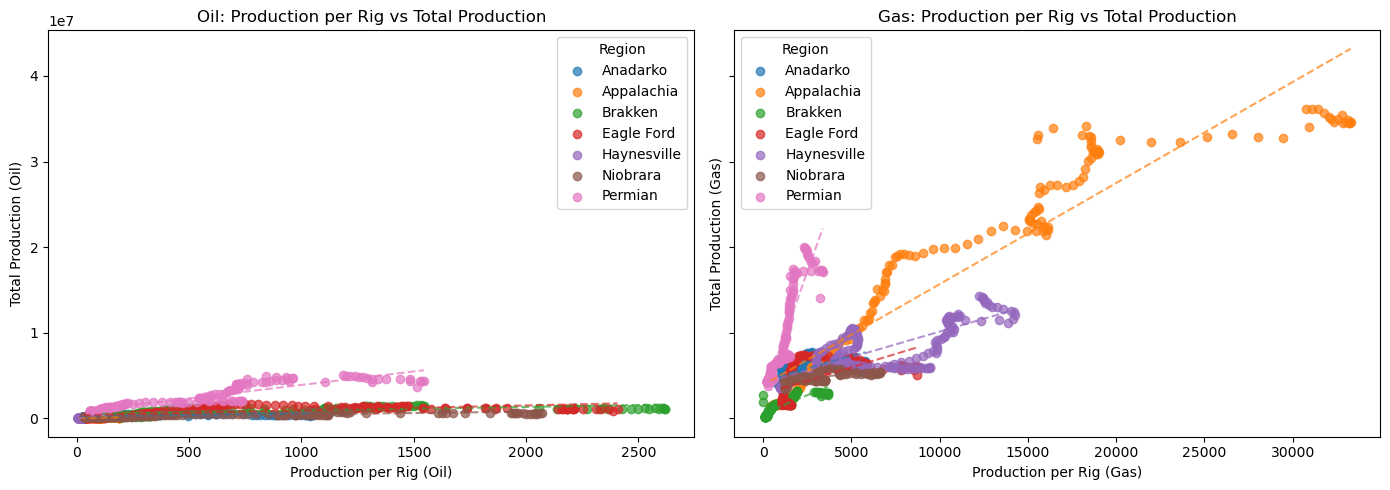

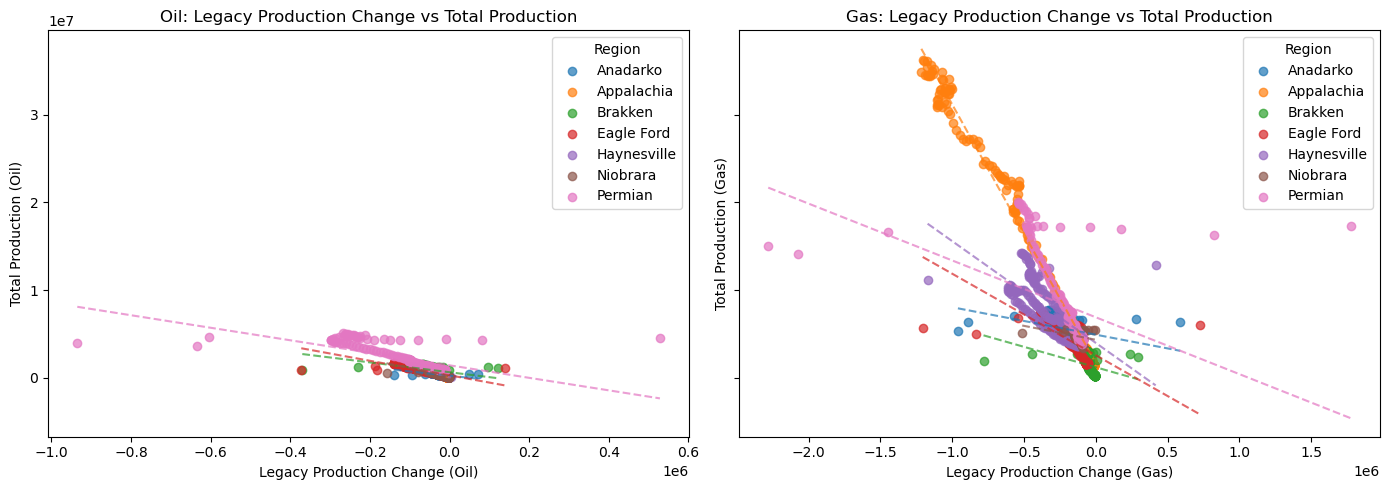

In [82]:
# Investigate relationship between rig count and Total Production (scatter subplots, colored by region, with regression lines)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for region in df_oil['Region'].unique():
    mask = df_oil['Region'] == region
    axes[0].scatter(df_oil.loc[mask, 'Rig Count'], df_oil.loc[mask, 'Total Production (Oil)'], label=region, alpha=0.7)
    # Regression line for Oil
    x = df_oil.loc[mask, 'Rig Count']
    y = df_oil.loc[mask, 'Total Production (Oil)']
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        axes[0].plot(np.sort(x), np.polyval(coeffs, np.sort(x)), linestyle='--', alpha=0.7)
axes[0].set_title('Oil: Rig Count vs Total Production')
axes[0].set_xlabel('Rig Count')
axes[0].set_ylabel('Total Production (Oil)')
axes[0].legend(title='Region')

for region in df_gas['Region'].unique():
    mask = df_gas['Region'] == region
    axes[1].scatter(df_gas.loc[mask, 'Rig Count'], df_gas.loc[mask, 'Total Production (Gas)'], label=region, alpha=0.7)
    # Regression line for Gas
    x = df_gas.loc[mask, 'Rig Count']
    y = df_gas.loc[mask, 'Total Production (Gas)']
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        axes[1].plot(np.sort(x), np.polyval(coeffs, np.sort(x)), linestyle='--', alpha=0.7)
axes[1].set_title('Gas: Rig Count vs Total Production')
axes[1].set_xlabel('Rig Count')
axes[1].set_ylabel('Total Production (Gas)')
axes[1].legend(title='Region')

plt.tight_layout()
plt.show()

# Investigate relationship between Production per Rig and Total Production (scatter subplots, colored by region, with regression lines)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for region in df_oil['Region'].unique():
    mask = df_oil['Region'] == region
    axes[0].scatter(df_oil.loc[mask, 'Production per Rig (Oil)'], df_oil.loc[mask, 'Total Production (Oil)'], label=region, alpha=0.7)
    x = df_oil.loc[mask, 'Production per Rig (Oil)']
    y = df_oil.loc[mask, 'Total Production (Oil)']
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        axes[0].plot(np.sort(x), np.polyval(coeffs, np.sort(x)), linestyle='--', alpha=0.7)
axes[0].set_title('Oil: Production per Rig vs Total Production')
axes[0].set_xlabel('Production per Rig (Oil)')
axes[0].set_ylabel('Total Production (Oil)')
axes[0].legend(title='Region')

for region in df_gas['Region'].unique():
    mask = df_gas['Region'] == region
    axes[1].scatter(df_gas.loc[mask, 'Production per Rig (Gas)'], df_gas.loc[mask, 'Total Production (Gas)'], label=region, alpha=0.7)
    x = df_gas.loc[mask, 'Production per Rig (Gas)']
    y = df_gas.loc[mask, 'Total Production (Gas)']
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        axes[1].plot(np.sort(x), np.polyval(coeffs, np.sort(x)), linestyle='--', alpha=0.7)
axes[1].set_title('Gas: Production per Rig vs Total Production')
axes[1].set_xlabel('Production per Rig (Gas)')
axes[1].set_ylabel('Total Production (Gas)')
axes[1].legend(title='Region')

plt.tight_layout()
plt.show()

# Investigate relationship between Legacy Production Change and Total Production (scatter subplots, colored by region, with regression lines)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for region in df_oil['Region'].unique():
    mask = df_oil['Region'] == region
    axes[0].scatter(df_oil.loc[mask, 'Legacy Production Change (Oil)'], df_oil.loc[mask, 'Total Production (Oil)'], label=region, alpha=0.7)
    x = df_oil.loc[mask, 'Legacy Production Change (Oil)']
    y = df_oil.loc[mask, 'Total Production (Oil)']
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        axes[0].plot(np.sort(x), np.polyval(coeffs, np.sort(x)), linestyle='--', alpha=0.7)
axes[0].set_title('Oil: Legacy Production Change vs Total Production')
axes[0].set_xlabel('Legacy Production Change (Oil)')
axes[0].set_ylabel('Total Production (Oil)')
axes[0].legend(title='Region')

for region in df_gas['Region'].unique():
    mask = df_gas['Region'] == region
    axes[1].scatter(df_gas.loc[mask, 'Legacy Production Change (Gas)'], df_gas.loc[mask, 'Total Production (Gas)'], label=region, alpha=0.7)
    x = df_gas.loc[mask, 'Legacy Production Change (Gas)']
    y = df_gas.loc[mask, 'Total Production (Gas)']
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        axes[1].plot(np.sort(x), np.polyval(coeffs, np.sort(x)), linestyle='--', alpha=0.7)
axes[1].set_title('Gas: Legacy Production Change vs Total Production')
axes[1].set_xlabel('Legacy Production Change (Gas)')
axes[1].set_ylabel('Total Production (Gas)')
axes[1].legend(title='Region')

plt.tight_layout()
plt.show()

### Build and Evaluated Random Forest Regressor Models for Oil and Gas Production.


Random Forest Model Score for Oil: 0.9696
Random Forest Model Score for Gas: 0.9946

Feature Importance for Oil:


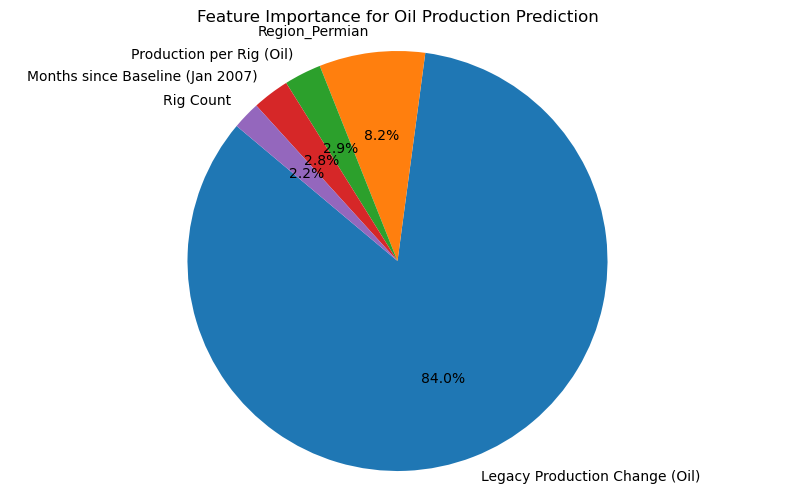


Feature Importance for Gas:
                             Feature  Importance
2           Production per Rig (Gas)    0.642717
3     Legacy Production Change (Gas)    0.272621
10                    Region_Permian    0.024327
0   Months since Baseline (Jan 2007)    0.021387
5                  Region_Appalachia    0.014451
1                          Rig Count    0.009950
8                 Region_Haynesville    0.008438
7                  Region_Eagle Ford    0.003535
6                     Region_Brakken    0.001817
4                    Region_Anadarko    0.000469
9                    Region_Niobrara    0.000289


In [ ]:
# Define features
num_features_oil = ['Months since Baseline (Jan 2007)', 'Rig Count', 'Production per Rig (Oil)', 'Legacy Production Change (Oil)']
num_features_gas = ['Months since Baseline (Jan 2007)', 'Rig Count', 'Production per Rig (Gas)', 'Legacy Production Change (Gas)']
cat_features = ['Region']

# Build the preprocessing and modeling pipelines for Oil with Random Forest
preprocessor_oil_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_oil),
        ('cat', OneHotEncoder(), cat_features)
    ]
)
oil_model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_oil_rf),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=17))
])

# Split the data into training and testing sets for Oil
X_oil = df_oil.drop(columns=['Total Production (Oil)'])
y_oil = df_oil['Total Production (Oil)']
X_train_oil, X_test_oil, y_train_oil, y_test_oil = train_test_split(X_oil, y_oil, test_size=0.2, random_state=17)

# Fit and evaluate the model for Oil
oil_model_rf.fit(X_train_oil, y_train_oil)
oil_score_rf = oil_model_rf.score(X_test_oil, y_test_oil)
print(f"Random Forest Model Score for Oil: {oil_score_rf:.4f}")

# Build the preprocessing and modeling pipelines for Gas with Random Forest
preprocessor_gas_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_gas),
        ('cat', OneHotEncoder(), cat_features)
    ]
)
gas_model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_gas_rf),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=17))
])
# Split the data into training and testing sets for Gas
X_gas = df_gas.drop(columns=['Total Production (Gas)'])
y_gas = df_gas['Total Production (Gas)']
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, test_size=0.2, random_state=17)

# Fit and evaluate the model for Gas
gas_model_rf.fit(X_train_gas, y_train_gas)
gas_score_rf = gas_model_rf.score(X_test_gas, y_test_gas)
print(f"Random Forest Model Score for Gas: {gas_score_rf:.4f}")

# Feature importance for Oil
importances_oil = oil_model_rf.named_steps['regressor'].feature_importances_
feature_names_oil = (num_features_oil + 
                     list(oil_model_rf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_features)))
importance_df_oil = pd.DataFrame({
    'Feature': feature_names_oil,
    'Importance': importances_oil
}).sort_values(by='Importance', ascending=False)

# Graph the feature importance for Oil (Pie Chart)
importance_df_oil = importance_df_oil[importance_df_oil ['Importance'] > 0.01]  # Filter out features with almost zero importance
print("\nFeature Importance for Oil:")
plt.figure(figsize=(10, 6))
plt.pie(importance_df_oil['Importance'], labels=importance_df_oil['Feature'], autopct='%1.1f%%', startangle=140)
plt.title('Feature Importance for Oil Production Prediction (Importance > 1%)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Feature importance for Gas
importances_gas = gas_model_rf.named_steps['regressor'].feature_importances_
feature_names_gas = (num_features_gas + 
                     list(gas_model_rf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_features)))
importance_df_gas = pd.DataFrame({
    'Feature': feature_names_gas,
    'Importance': importances_gas
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance for Gas:")
print(importance_df_gas)